In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2,RealAmplitudes

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from itertools import product
from scipy.optimize import minimize

In [2]:
n_qubits = 4
n_reps = 5
#nShots = 2**16
nShots = int(1e5)
print("nShots = ", nShots)

target_probs = np.random.rand(2**n_qubits)  # Example
target_probs = target_probs/target_probs.sum()
bitstrings = [''.join(bits) for bits in product('01', repeat=n_qubits)]
target_dict = dict(zip(bitstrings, target_probs))


nShots =  100000


In [3]:

class QCBM:
    def __init__(self,n_qubits, n_reps,  target_dict,shots=2**15, scales = np.array([0.01, 0.1, 1, 10, 100]),seed=None):
        self.n_qubits = n_qubits
        self.n_reps = n_reps
        self.shots = shots
        self.seed = seed
        self.scales = scales

        # Build quantum circuit
        self.qc = QuantumCircuit(n_qubits)
        self.ansatz = RealAmplitudes(num_qubits=n_qubits, reps=n_reps, parameter_prefix='w')
        self.parameters = list(self.ansatz.parameters)
        self.qc.compose(self.ansatz, inplace=True)
        self.qc.measure_all()

        # Backend and tools
        self.backend = AerSimulator(seed_simulator=seed)
        self.pm_sim = generate_preset_pass_manager(backend=self.backend, optimization_level=3)
        self.sampler = Sampler(mode = self.backend)
        
        # Precompute bitstrings and target vector q
        self.bitstrings = sorted(set(target_dict.keys()))
        self.X = np.array([self.bitstring_to_array(bs) for bs in self.bitstrings])
        self.q = np.array([target_dict[bs] if bs in target_dict else 0 for bs in self.bitstrings])
        
        self.theta = self.random_theta()
        # History for loss tracking
        self.loss_history = []

    def sample(self, theta):

        # Transpile circuit
        transpiled_qc = self.pm_sim.run(self.qc)
        # Run sampler
   
        job = self.sampler.run([(transpiled_qc, theta)], shots=self.shots)
        result = job.result()[0].data.meas.get_counts()
        # Normalize counts to probabilities
        probs = {k: v / self.shots for k, v in result.items()}
        return probs
    
    def loss(self, theta):

        result = self.sample(theta)
       
        p = np.array([result[bs] if bs in result else 0 for bs in self.bitstrings])
        return self.getMMD2(p, self.q, self.X, scales = self.scales)

    @staticmethod
    def bitstring_to_array(bs): # Converting bitstring to vector arrays for kernel evaluation
        return np.array([int(b) for b in bs])

    @staticmethod
    def getMMD2(p, q, X,scales):
        sq_dists = np.linalg.norm(X[:, None] - X[None, :], axis=-1) ** 2
        gamma = 1 / (2 * scales ** 2)
        K = np.exp(-gamma[:,None,None] * sq_dists).sum(axis = 0)/len(scales)
        return (p - q) @ K @ (p - q)

    def random_theta(self):
        return np.random.uniform(0, 2 * np.pi, len(self.parameters))
    
    def train(self, maxiter=200):
        theta0 = self.random_theta()

        def callback(theta):
            current_loss = self.loss(theta)
            self.loss_history.append(current_loss)

        res = minimize(self.loss, theta0, method='COBYLA', callback=callback, options={'maxiter': maxiter})
        return res.x


In [4]:
qcbm = QCBM(n_qubits,5,target_dict,shots = nShots)
#theta = qcbm.random_theta()
qcbm.sample(qcbm.theta)
qcbm.theta = qcbm.train()

In [5]:
qcbm_s = QCBM(n_qubits,5,target_dict,shots = nShots,scales = np.array([1]))
#theta = qcbm.random_theta()
qcbm_s.sample(qcbm.theta)
qcbm_s.theta = qcbm_s.train()

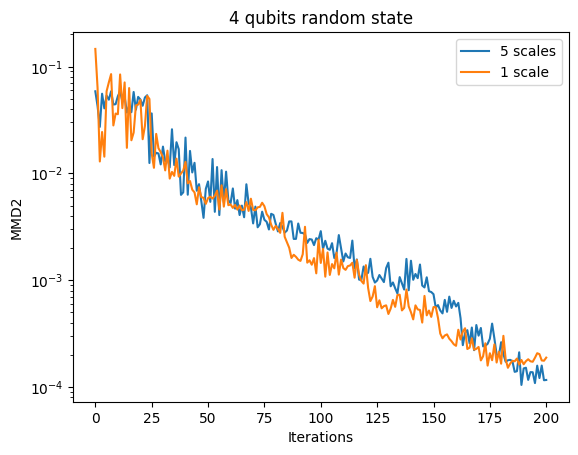

In [6]:
plt.plot(qcbm.loss_history,label = "5 scales")
plt.plot(qcbm_s.loss_history,label = "1 scale")
plt.xlabel('Iterations')
plt.ylabel("MMD2")
plt.title(f"{n_qubits} qubits random state")
plt.yscale('log')
plt.legend()

In [9]:
def plotDist(qcbm,target_dict,qcbm_label = 'QCBM',plotTarget = True):
    d_qcbm = qcbm.sample(qcbm.theta)
    h_qcbm = []
    h_target = []
    
    for key in target_dict.keys():
        h_target.append(target_dict[key])
        if key in d_qcbm.keys():
            h_qcbm.append(d_qcbm[key])
        else:
            h_qcbm.append(0)
    if plotTarget:
        plt.bar(range(len(target_dict.keys())),h_target,label = 'Target')
    plt.bar(range(len(target_dict.keys())),h_qcbm,alpha = 0.3,label = qcbm_label)
    plt.legend()
        
        
        

Text(0, 0.5, 'Probability')

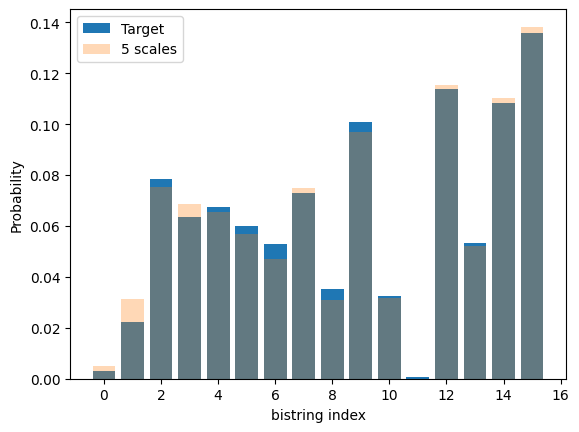

In [11]:
plotDist(qcbm,target_dict,qcbm_label = '5 scales')
#plotDist(qcbm_s,target_dict,qcbm_label = '1 scale',plotTarget = False)
plt.xlabel("bistring index")
plt.ylabel("Probability")

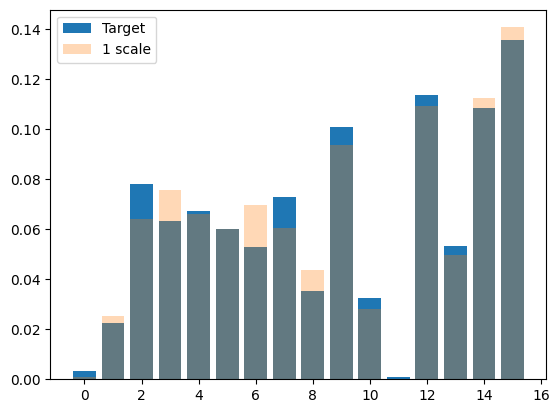

In [12]:
plotDist(qcbm_s,target_dict,qcbm_label = '1 scale')